# Swissroads Project: 08 - Convulational network  

## General presentation
This is the first notebook of the Swissroad classification project. The aim of this project is to construct several classifiers to identify vehicles photographied in the streets around the Swiss School: EPFL. The project will be split into 9 jupyter notebook, each performing a specific task.
Our dataset comprises color photographies of 6 different types of vehicles: 
* Bikes
* Cars 
* Motorcycles
* Trucks 
* Vans 
* Others (for example, buses, scooters, etc.) 
Our data is already split into a train, validation and test set, with respectively: 280, 139 and 50 images of sizes 250x250. 
This is a relatively small dataset. When state of the art models trained for similar tasks on larger datasets are already documented and available, a beneficial option is to use one of these pre-trained model on our own dataset, either for classification purposes directly, or as a way of extracting features from the deep layers to inject these features in other machine learning models. This option is beneficial as it allows us to benefit from information obtained on a very large dataset and allows us to save time, as training complex convolutional networks is computationally expensive and can be very time consuming especially on a personal computer. 

For this project, we will use the Inception_v3 model available on the tensorflow hub to extract the 2048 most important features and use them in different classifiers: 
* A k-nearest neighbors classifiers
* A simple decision tree
* A logistic regression model
* Non linear classifiers such as Random Forest and SVMs 
* A dense network

Finally, we will also attempt to achieve the same level of accuracy by training our own convolutional network from scratch on our specific dataset.


## Aim of this notebook  


In this jupyter notebook, we will work with with our raw data to train a convolutional neural network classifier on our data and evaluate if we can do as well as the Inception_v3 convNet available on the tensorflow hub. 


In [1]:
# loading libraries

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


As our dataset is relatively small, we will use data augmentation techniques when loading the training dataset, randomly applying rotations and color shifts to the images in the training set to increase the diversity of the training images. 

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create image generator
train_generator = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
test_generator = ImageDataGenerator(rescale=1/255)

In [3]:
# Train, validation and test sets
trainset = train_generator.flow_from_directory(
    os.path.join('swissroads', 'train'), batch_size=16, target_size=(256, 256),
    #os.path.join('example', 'train'), batch_size=32, target_size=(224, 224),
    shuffle=True, class_mode = 'sparse')
validset = test_generator.flow_from_directory(
    os.path.join('swissroads', 'valid'), batch_size=16, target_size=(256, 256),
    #os.path.join('example', 'valid'), batch_size=32, target_size=(224, 224),
    shuffle=False, class_mode = 'sparse')
testset = test_generator.flow_from_directory(
    os.path.join('swissroads', 'test'), batch_size=16, target_size=(256, 256),
    shuffle=False, class_mode = 'sparse')

Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


To design our convolutional neural network, we will take our inspiration from the VGG16 neural network. This architecture is a simple one, where we alternate convolutional layers with a 0-padding and max-pooling layers with a stride of 2.
We chose to take inspiration from this architecture as this is a well established algorithm that is easy to understand and implement and has proven its performance on image recognation problems. 

The general architecture of our CNN is as follows:

In [4]:
import tensorflow.keras as keras
# Convolutional Network
model = keras.Sequential()
model.add(keras.layers.Conv2D(filters=10, kernel_size=3, strides=1, padding = "valid",
                                input_shape=(256, 256, 3)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=2, strides = 2))
model.add(keras.layers.Conv2D(filters=20, kernel_size=5, strides=2, padding = "valid"))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=2, strides = 2))
model.add(keras.layers.Conv2D(filters=40, kernel_size=5, strides=2, padding = "valid"))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=2, strides = 2))
model.add(keras.layers.Dropout(rate = 0.2))


model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(trainset.num_classes))
model.add(keras.layers.Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 10)      280       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 10)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 10)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 20)        5020      
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 20)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 40)        20040     
__________

In order to achieve the best accuracy for our CNN, we will fine tune some of its hyper parameters.
For this classifier, we will tune: 
* batch_sizehow many images are passed to the model at a time
* drop_out rate: the percentage of activated nodes in the drop out layer
* initialization method: the method used to initialize the weitght at each iteration; we choose between normal (random values drawn from a normal distribution), uniform (random values drawn from a uniform distribution) and zeros.  

Finally, we will use the Adam optimizer as this is an adaptative optimizer that trains its learning rate during the process. 

In order to fight over fitting and try to save time on the computation, we will also use an early callback that will top the training when the validation_loss stops decreasing for at least 10 epochs. 


In [5]:
import math
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import ParameterGrid


# fix random seed for reproducibility
seed = 20211101
np.random.seed(seed)

# define the grid search parameters
batch_size = [8, 16]
epochs = [50]
rate = [0, 0.2, 0.5]
init_mode = ['uniform', 'normal', 'zero']


param_grid = [dict(batch_size=batch_size, epochs=epochs, rate=rate, init_mode = init_mode),
             ]
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode = "min", patience =10)
grid_results = []
for step in ParameterGrid(param_grid):
    print(step)
     # create model
    step_model = keras.Sequential()
    step_model.add(keras.layers.Conv2D(filters=10, kernel_size=3, strides=1, padding = "valid", kernel_initializer=step['init_mode'],
                                input_shape=(256, 256, 3)))
    step_model.add(keras.layers.Activation('relu'))
    step_model.add(keras.layers.MaxPool2D(pool_size=2, strides = 2))
    step_model.add(keras.layers.Conv2D(filters=20, kernel_size=5, strides=2, padding = "valid", kernel_initializer=step['init_mode']))
    step_model.add(keras.layers.Activation('relu'))
    step_model.add(keras.layers.MaxPool2D(pool_size=2, strides = 2))
    step_model.add(keras.layers.Conv2D(filters=40, kernel_size=5, strides=2, padding = "valid", kernel_initializer=step['init_mode']))
    step_model.add(keras.layers.Activation('relu'))
    step_model.add(keras.layers.MaxPool2D(pool_size=2, strides = 2))
    step_model.add(keras.layers.Dropout(rate = step['rate']))


    step_model.add(keras.layers.Flatten())
    step_model.add(keras.layers.Dense(trainset.num_classes))
    step_model.add(keras.layers.Activation('softmax'))
    step_model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
    step_history = step_model.fit_generator(
        trainset,
        steps_per_epoch=math.ceil(280 // step["batch_size"]),
        epochs=step['epochs'],
        validation_data=validset, callbacks = [es],
    shuffle = True)
    grid_results.append([step['batch_size'],step['rate'],step['init_mode'],
                        len(step_history.history['acc']),
                        np.mean(step_history.history['acc'][-5:]),
                        np.mean(step_history.history['val_acc'][-5:]), 
                        np.mean(step_history.history['loss'][-5:]),
                        np.mean(step_history.history['val_loss'][-5:])])


    

{'batch_size': 8, 'epochs': 50, 'init_mode': 'uniform', 'rate': 0}
Epoch 1/50
35/35 [==============================] - 12s 334ms/step - loss: 1.7720 - acc: 0.2286 - val_loss: 1.7700 - val_acc: 0.2230
Epoch 2/50
35/35 [==============================] - 10s 280ms/step - loss: 1.7507 - acc: 0.2394 - val_loss: 1.7349 - val_acc: 0.2374
Epoch 3/50
35/35 [==============================] - 10s 279ms/step - loss: 1.7477 - acc: 0.2357 - val_loss: 1.7233 - val_acc: 0.2806
Epoch 4/50
35/35 [==============================] - 10s 276ms/step - loss: 1.7322 - acc: 0.2822 - val_loss: 1.6780 - val_acc: 0.3525
Epoch 5/50
35/35 [==============================] - 10s 276ms/step - loss: 1.6607 - acc: 0.3517 - val_loss: 1.5802 - val_acc: 0.4388
Epoch 6/50
35/35 [==============================] - 10s 275ms/step - loss: 1.6321 - acc: 0.3748 - val_loss: 1.4615 - val_acc: 0.4964
Epoch 7/50
35/35 [==============================] - 10s 275ms/step - loss: 1.6211 - acc: 0.3589 - val_loss: 1.4638 - val_acc: 0.4604
Ep

In [6]:
df_grid_results = pd.DataFrame(grid_results, columns = ['batch_size', 'rate', 'init_mode', 'nb_epochs', 'mean_last_5_acc', 'mean_last_5_val_acc', 'mean_last_5_loss', 'mean_last_5_val_loss'])

In [7]:
df_grid_results.to_csv('cnn_grid_result.csv')

In [8]:
df_grid_results =pd.read_csv('cnn_grid_result.csv')

In [9]:
df_grid_results.sort_values(by='mean_last_5_val_acc', ascending = False).head(10)

,Unnamed: 0,batch_size,rate,init_mode,nb_epochs,mean_last_5_acc,mean_last_5_val_acc,mean_last_5_loss,mean_last_5_val_loss
1,1,8,0.2,uniform,50,0.643460,0.637410,0.949868,1.023804
4,4,8,0.2,normal,50,0.688459,0.634532,0.842090,1.052713
5,5,8,0.5,normal,35,0.552206,0.633094,1.136759,1.057356
3,3,8,0.0,normal,39,0.680515,0.624460,0.870522,0.986763
2,2,8,0.5,uniform,50,0.583476,0.621583,1.087361,1.059031
11,11,16,0.5,uniform,50,0.493448,0.597122,1.317840,1.084931
0,0,8,0.0,uniform,37,0.569853,0.592806,1.137326,1.041634
13,13,16,0.2,normal,50,0.519101,0.592806,1.193436,1.040732
14,14,16,0.5,normal,50,0.511521,0.585612,1.296975,1.095085
12,12,16,0.0,normal,45,0.553515,0.568345,1.159464,1.143710


The best accuracy is obtain with a batch_size = 8 , weights initiated with a uniform distribution and a drop out rate of 0.2. The best accuracy on the validtion set (averaged on the last 5 epochs) is around 64%. 

We can now fit a final time the model with the optimal parameters, predict the values for the test set and evaluate the final test set accuracy. 

In [10]:
best_params = df_grid_results.sort_values(by='mean_last_5_val_acc', ascending = False).head(1)

In [11]:
final_cnn_model = keras.Sequential()
final_cnn_model.add(keras.layers.Conv2D(filters=10, kernel_size=3, strides=1, padding = "valid", kernel_initializer=best_params.iloc[0]['init_mode'],input_shape=(256, 256, 3)))
final_cnn_model.add(keras.layers.Activation('relu'))
final_cnn_model.add(keras.layers.MaxPool2D(pool_size=2, strides = 2))
final_cnn_model.add(keras.layers.Conv2D(filters=20, kernel_size=5, strides=2, padding = "valid", kernel_initializer=best_params.iloc[0]['init_mode']))
final_cnn_model.add(keras.layers.Activation('relu'))
final_cnn_model.add(keras.layers.MaxPool2D(pool_size=2, strides = 2))
final_cnn_model.add(keras.layers.Conv2D(filters=40, kernel_size=5, strides=2, padding = "valid", kernel_initializer=best_params.iloc[0]['init_mode']))
final_cnn_model.add(keras.layers.Activation('relu'))
final_cnn_model.add(keras.layers.MaxPool2D(pool_size=2, strides = 2))
final_cnn_model.add(keras.layers.Dropout(rate = best_params.iloc[0]['rate']))


final_cnn_model.add(keras.layers.Flatten())
final_cnn_model.add(keras.layers.Dense(trainset.num_classes))
final_cnn_model.add(keras.layers.Activation('softmax'))
final_cnn_model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
final_history = final_cnn_model.fit_generator(
    trainset,
    steps_per_epoch=math.ceil(280 // best_params.iloc[0]["batch_size"]),
    epochs=100,
    validation_data=validset, callbacks = [es],
shuffle = True)

Epoch 1/100
35/35 [==============================] - 10s 294ms/step - loss: 1.7718 - acc: 0.2285 - val_loss: 1.7379 - val_acc: 0.2374
Epoch 2/100
35/35 [==============================] - 10s 286ms/step - loss: 1.7434 - acc: 0.2608 - val_loss: 1.7345 - val_acc: 0.3237
Epoch 3/100
35/35 [==============================] - 10s 287ms/step - loss: 1.7406 - acc: 0.2733 - val_loss: 1.6925 - val_acc: 0.3309
Epoch 4/100
35/35 [==============================] - 10s 288ms/step - loss: 1.7024 - acc: 0.3090 - val_loss: 1.5660 - val_acc: 0.3813
Epoch 5/100
35/35 [==============================] - 10s 276ms/step - loss: 1.6409 - acc: 0.3857 - val_loss: 1.5441 - val_acc: 0.4388
Epoch 6/100
35/35 [==============================] - 10s 278ms/step - loss: 1.5927 - acc: 0.3801 - val_loss: 1.4710 - val_acc: 0.4820
Epoch 7/100
35/35 [==============================] - 10s 277ms/step - loss: 1.5514 - acc: 0.3948 - val_loss: 1.4160 - val_acc: 0.4820
Epoch 8/100
35/35 [==============================] - 10s 276ms

In [12]:
(test_loss, test_accuracy) = final_cnn_model.evaluate_generator(testset)

print('Test loss: {:.2f}'.format(test_loss))
print('Test accuracy: {:.2f}%'.format(100*test_accuracy))

Test loss: 1.27
Test accuracy: 54.00%


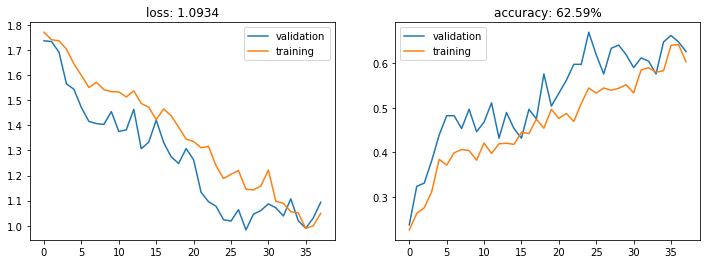

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss values
ax1.set_title('loss: {:.4f}'.format(final_history.history['val_loss'][-1]))
ax1.plot(final_history.history['val_loss'], label='validation')
ax1.plot(final_history.history['loss'], label='training')
ax1.legend()

# plot accuracy values
ax2.set_title('accuracy: {:.2f}%'.format(final_history.history['val_acc'][-1]*100))
ax2.plot(final_history.history['val_acc'], label='validation')
ax2.plot(final_history.history['acc'], label='training')
ax2.legend()

plt.show()

The architecture we tried here is only one of all the ones that were tested for this project. It has a simple architecture and is the one that achieved consistently the highest test accuracy for a lesser computational cost. Trying more complicated architectures often yielded in the model getting stuck in a local minimum where the model wasn't learning even when we increased the number of epochs and were much more expensive.  

After training the model for 50 epoch, the validation loss stopped increasing and we stopped trainig the model. The accuracy on the test set was 54%. 
This is very inferior to all the other methods we have tried so far, that were performed after extracting a set of 2048 important features thanks to a pretrained model. 

This can be explained by the fact that our CNN is way more simpler than the inception_v3 CNN, as well as by the fact that our CNN was trained on a much smaller dataset. 

Finally, we save the our result in order to do a final comparison of all the methods we have implemented so far. 


In [14]:
np.savez('results/09_CNN.npz', test_accuracy=test_accuracy)